<p><font size="6"><b> Case study: air quality data of European monitoring stations (AirBase)</b></font></p><br>
**AirBase (The European Air quality dataBase): hourly measurements of all air quality monitoring stations from Europe. **

> *DS Data manipulation, analysis and visualisation in Python*  
> *December, 2017*

> *© 2016, Joris Van den Bossche and Stijn Van Hoey  (<mailto:jorisvandenbossche@gmail.com>, <mailto:stijnvanhoey@gmail.com>). Licensed under [CC BY 4.0 Creative Commons](http://creativecommons.org/licenses/by/4.0/)*

---

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 8

In the previous notebook, we processed some raw data files of the AirBase air quality data. As a reminder, the data contains hourly concentrations of nitrogen dioxide (NO2) for 4 different measurement stations:

- FR04037 (PARIS 13eme): urban background site at Square de Choisy
- FR04012 (Paris, Place Victor Basch): urban traffic site at Rue d'Alesia
- BETR802: urban traffic site in Antwerp, Belgium
- BETN029: rural background site in Houtem, Belgium

See http://www.eea.europa.eu/themes/air/interactive/no2

# Importing and quick exploration

We processed the individual data files in the previous notebook, and saved it to a csv file `airbase_data.csv`. Let's import the file here (if you didn't finish the previous notebook, a version of the dataset is also available in `../data/airbase_data.csv`):

In [2]:
alldata = pd.read_csv('airbase_data.csv', index_col=0, parse_dates=True)

We only use the data from 1999 onwards:

In [3]:
data = alldata['1999':].copy()

Som first exploration with the *typical* functions:

In [4]:
data.head() # tail()

,FR04037,BETR801,FR04012,BETN029
1999-01-01 00:00:00,68.0,27.0,105.0,13.0
1999-01-01 01:00:00,70.0,33.0,116.0,15.0
1999-01-01 02:00:00,72.0,24.0,114.0,16.0
1999-01-01 03:00:00,72.0,26.0,91.0,18.0
1999-01-01 04:00:00,74.0,NaN,81.0,19.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 122736 entries, 1999-01-01 00:00:00 to 2012-12-31 23:00:00
Data columns (total 4 columns):
FR04037    120384 non-null float64
BETR801    106628 non-null float64
FR04012    119448 non-null float64
BETN029    111989 non-null float64
dtypes: float64(4)
memory usage: 4.7 MB


In [6]:
data.describe(percentiles=[0.1, 0.5, 0.9])

,FR04037,BETR801,FR04012,BETN029
count,120384.000000,106628.000000,119448.000000,111989.00000
mean,40.040005,46.728969,87.993261,16.42093
std,23.024347,21.708333,41.317684,12.31968
min,0.000000,1.000000,0.000000,1.00000
10%,14.000000,21.000000,37.000000,4.00000
50%,37.000000,45.000000,88.000000,12.00000
90%,70.000000,75.000000,139.000000,34.00000
max,256.000000,339.000000,358.000000,105.00000


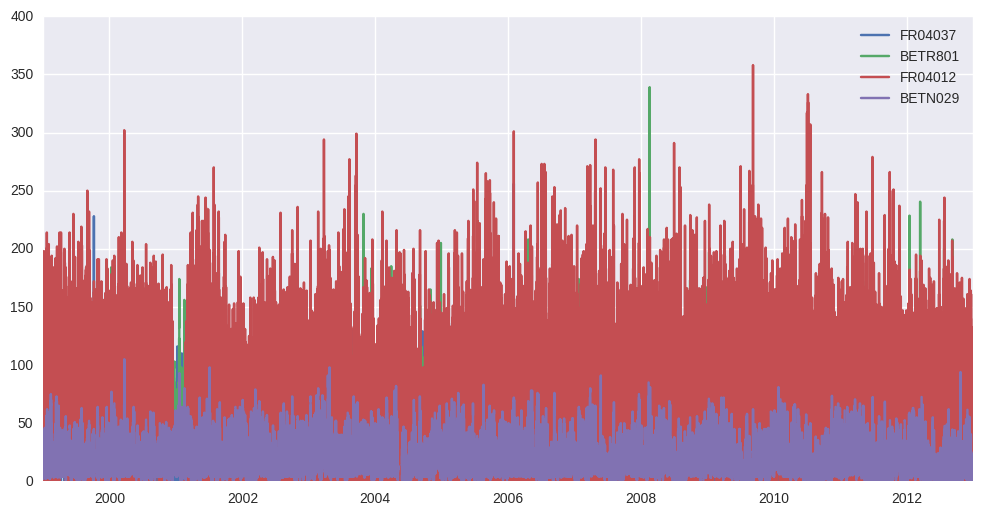

In [7]:
data.plot(figsize=(12,6))

<div class="alert alert-warning">
<b>ATTENTION!</b>: <br><br>

When just using `.plot()` without further notice (selection, aggregation,...)
 <ul>
  <li>Risk of running into troubles by overloading your computer processing (certainly with looooong time series)</li>
  <li>Not always the most informative/interpretable visualisation</li>
</ul>
</div>

**Plot only a subset**

Why not just using the `head`/`tail` possibilities?

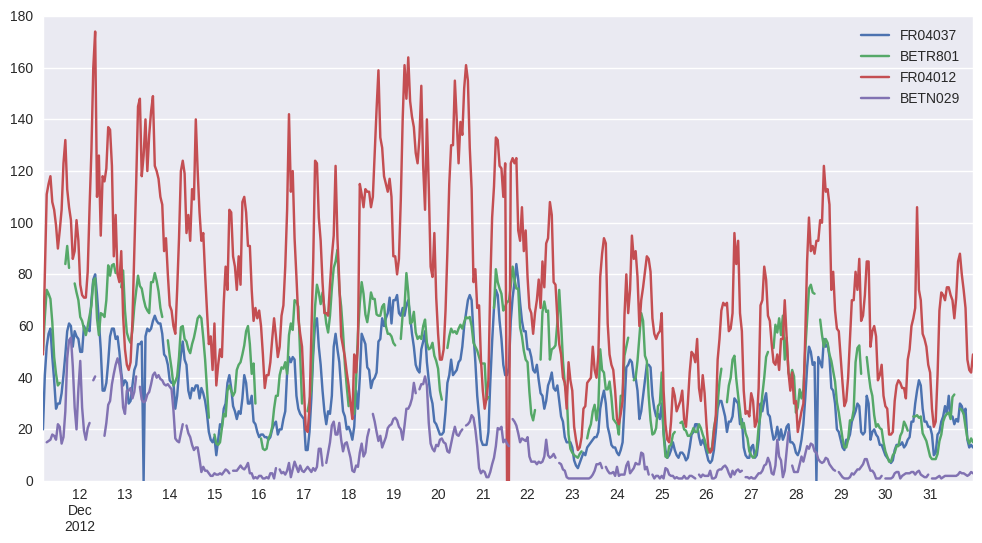

In [8]:
data.tail(500).plot(figsize=(12,6))

**Summary figures**

Use summary statistics...

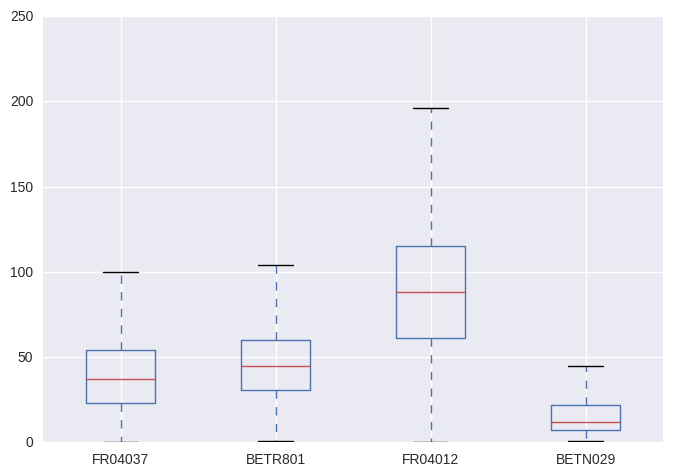

In [9]:
data.plot(kind='box', ylim=[0,250])

Also with seaborn plots function, just start with some subsets as first impression...

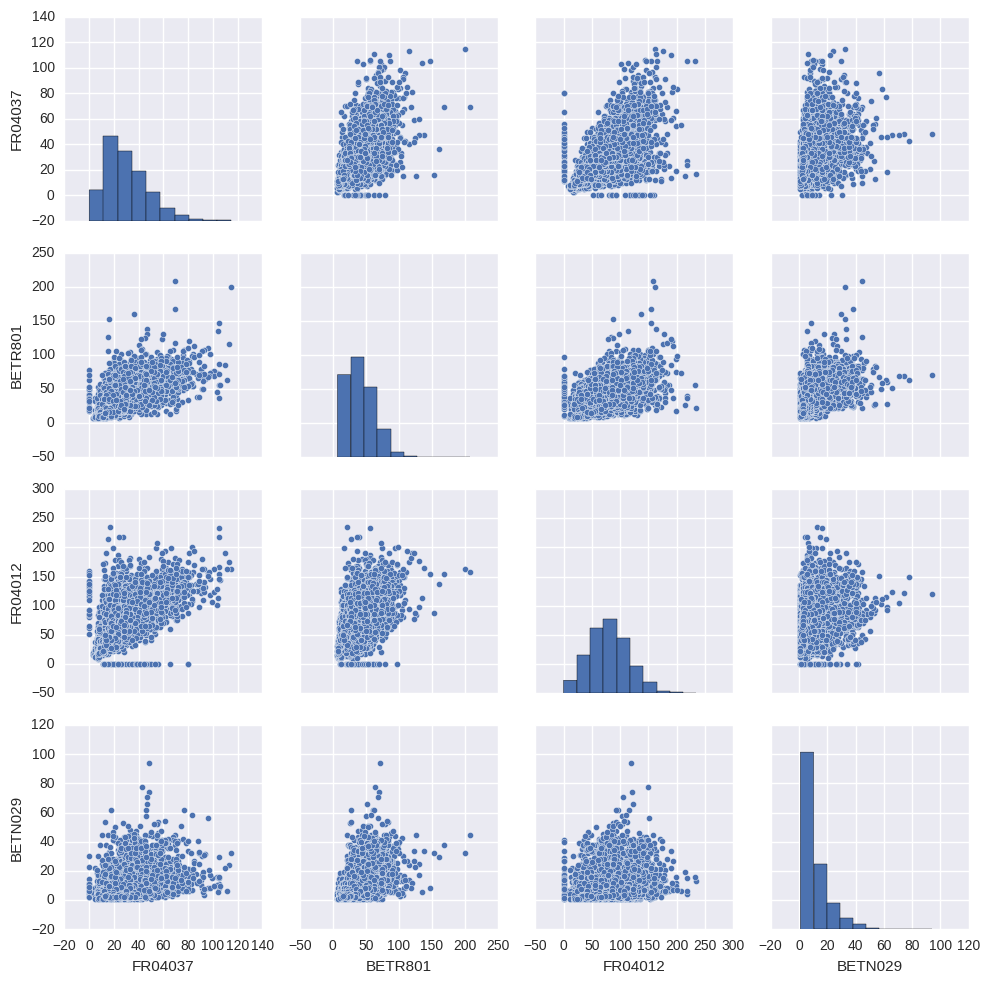

In [10]:
sns.pairplot(data.tail(5000).dropna())

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>Try out yourself alternative visualisations provided by [Pandas](http://pandas.pydata.org/pandas-docs/version/0.18.1/visualization.html) and [Seaborn](http://seaborn.pydata.org/examples/).</li>
</ul>
</div>

# Exercises

<div class="alert alert-warning">

<b>REMINDER</b>: <br><br>

Take a look at the [Timeseries notebook](pandas_04_time_series_data.ipynb) when you require more info about...

 <ul>
  <li>`resample`</li>
  <li>string indexing of DateTimeIndex</li>
</ul><br><br>

Take a look at the [matplotlib/seaborn notebook](matplotlib_seaborn.ipynb) when you require more info about the plot requirements.

</div>

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>Plot the monthly mean and median concentration of the 'FR04037' station for the years 2009 - 2012 in a single figure/ax</li>
</ul>
</div>

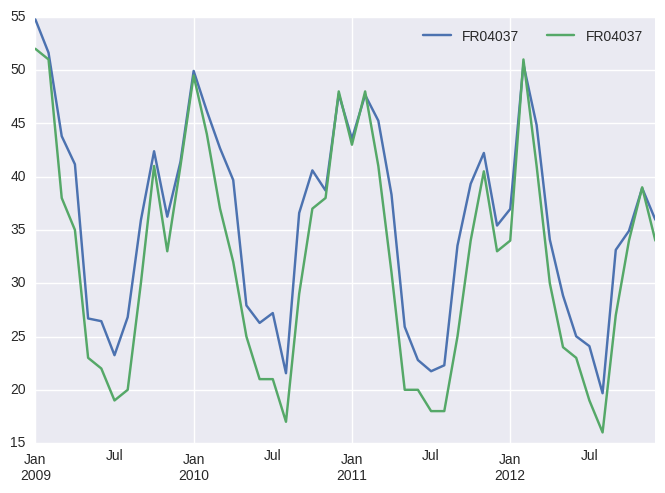

In [11]:
fig, ax = plt.subplots()
data.loc['2009':, 'FR04037'].resample('M').mean().plot(ax=ax)
data.loc['2009':, 'FR04037'].resample('M').median().plot(ax=ax)
ax.legend(ncol=2);

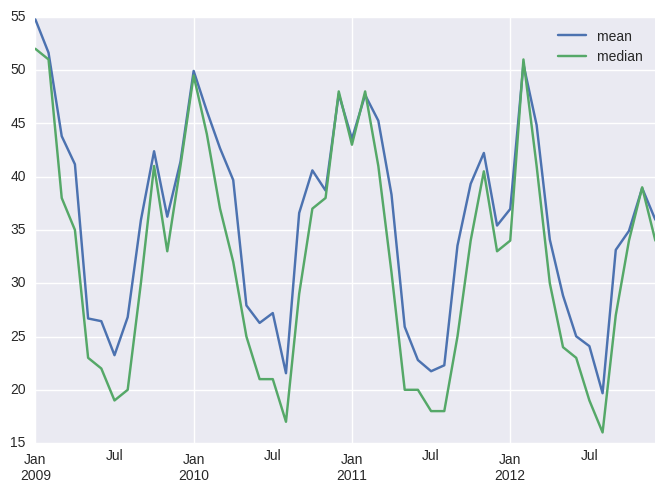

In [12]:
data.loc['2009':, 'FR04037'].resample('M').agg(['mean', 'median']).plot()

<div class="alert alert-success">

<b>EXERCISE</b>

 <ul>
  <li>Make a violin plot for January 2011 until August 2011 (check out the documentation to improve the plotting settings)</li>
  <li>Change the y-label to 'NO$_2$ concentration (µg/m³)'</li>
</ul><br>

 (for the violin plot documentation, check the examples at [seaborn](http://seaborn.pydata.org/examples/index.html) )
</div>

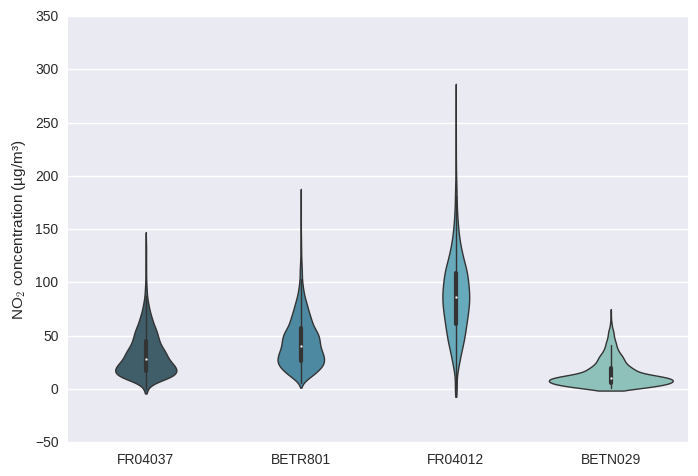

In [13]:
fig, ax = plt.subplots()
sns.violinplot(data=data['2011-01': '2011-08'], palette="GnBu_d", 
                   bw=.2, cut=1, linewidth=1, ax=ax) # some additional settings to improve the appearance
ax.set_ylabel("NO$_2$ concentration (µg/m³)")

<div class="alert alert-success">

<b>EXERCISE</b>

 <ul>
  <li>Make a bar plot of the mean of each of the stations in the year 2012 (check the documentation of Pandas plot to adapt the rotation of the labels)</li>
  <li>Change the y-label to 'NO$_2$ concentration (µg/m³)'</li>
  <li>Add a 'darkorange' horizontal line on the ax for the y-value 40 µg/m³ (command for horizontal line from matplotlib: `axhline`)</li>
  <li>[Place the text](matplotlib_seaborn.ipynb) just 'Yearly limit is 40 µg/m³' above the 'darkorange' line</li>
</ul><br>

</div>

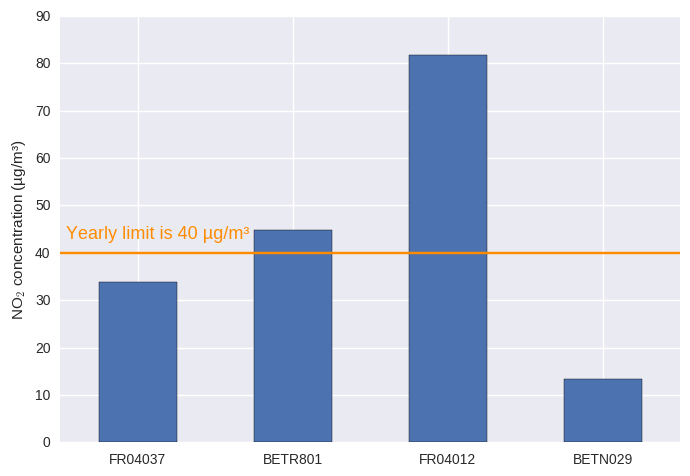

In [16]:
fig, ax = plt.subplots()
data['2012'].mean().plot(kind='bar', ax=ax, rot=0)
ax.set_ylabel("NO$_2$ concentration (µg/m³)")
ax.axhline(y=40., color='darkorange')
ax.text(0.01, 0.48, 'Yearly limit is 40 µg/m³',
        horizontalalignment='left', fontsize=13, 
        transform=ax.transAxes, color='darkorange')

<div class="alert alert-success">

<b>EXERCISE</b>

 <ul>
  <li>For the data from 1999 till the end, plot the yearly averages</li>
  <li>For the same period, add the overall mean (all stations together) as an additional line to the graph, use a thicker black line (`linewidt=4` and `linestyle='--'`)</li>
  <li>[OPTIONAL] Add a legend above the ax for all lines</li>
  

</ul>
</div>


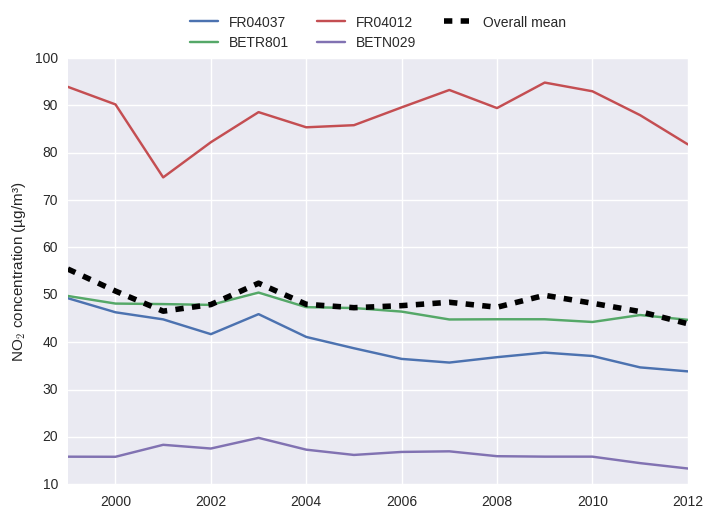

In [17]:
fig, ax = plt.subplots()

data['1999':].resample('A').mean().plot(ax=ax)
data['1999':].mean(axis=1).resample('A').mean().plot(color='k', 
                                            linestyle='--', 
                                            linewidth=4, 
                                            ax=ax, 
                                            label='Overall mean')
ax.legend(loc='center', ncol=3, 
          bbox_to_anchor=(0.5, 1.06))
ax.set_ylabel("NO$_2$ concentration (µg/m³)")

<div class="alert alert-info">

<b>REMEMBER</b>: <br><br>

`resample` is a specifal version of `groupby`. For example, taking annual means with `data.resample('A', 'mean')` is equivalent to `data.groupby(data.index.year).mean()` (but the result of `resample` still has a DatetimeIndex).<br><br>

Checking the index of the resulting DataFrame when using **groupby** instead of resample: You'll notice that the Index lost the DateTime capabilities:

<code>
> data.groupby(data.index.year).mean().index
</code>
Results in:
<code>
Int64Index([1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
            2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
            2012],
           dtype='int64')$
</code>

<br>
When using **resample**, we keep the DateTime capabilities:

<code>
> data.resample('A').mean().index
</code>
Results in:
<code>
DatetimeIndex(['1999-12-31', '2000-12-31', '2001-12-31', '2002-12-31',
               '2003-12-31', '2004-12-31', '2005-12-31', '2006-12-31',
               '2007-12-31', '2008-12-31', '2009-12-31', '2010-12-31',
               '2011-12-31', '2012-12-31'],
              dtype='datetime64[ns]', freq='A-DEC')
</code>
<br>
But, `groupby` is more flexible and can also do resamples that do not result in a new continuous time series, e.g. by grouping by the hour of the day to get the diurnal cycle.
</div>

<div class="alert alert-success">

<b>EXERCISE</b>

 <ul>
  <li>How does the *typical yearly profile* (typical averages for the different months) look like for the different stations? (add a 'month' column as a first step)</li>

</ul>
</div>

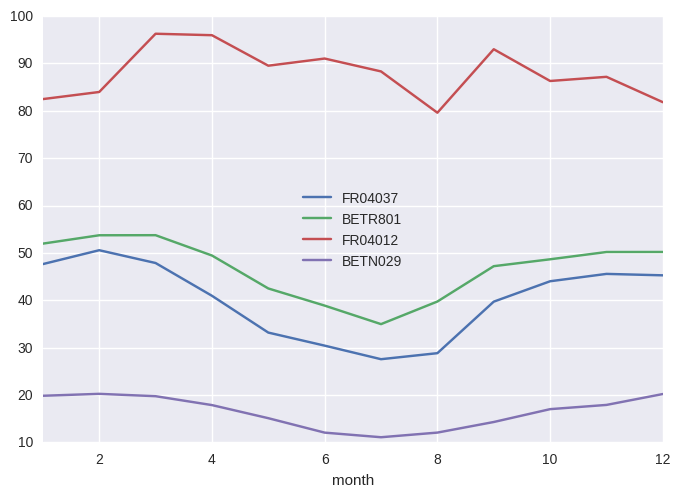

In [18]:
# add a column to the dataframe that indicates the month (integer value of 1 to 12):
data['month'] = data.index.month

# now, we can calculate the mean of each month over the different years:
data.groupby('month').mean()

# plot the typical monthly profile of the different stations:
data.groupby('month').mean().plot()

In [19]:
data = data.drop("month", axis=1)

<div class="alert alert-success">

<b>EXERCISE</b>

 <ul>
  <li>Plot the weekly 95% percentiles of the concentration in 'BETR801' and 'BETN029' for 2011</li>

</ul>
</div>

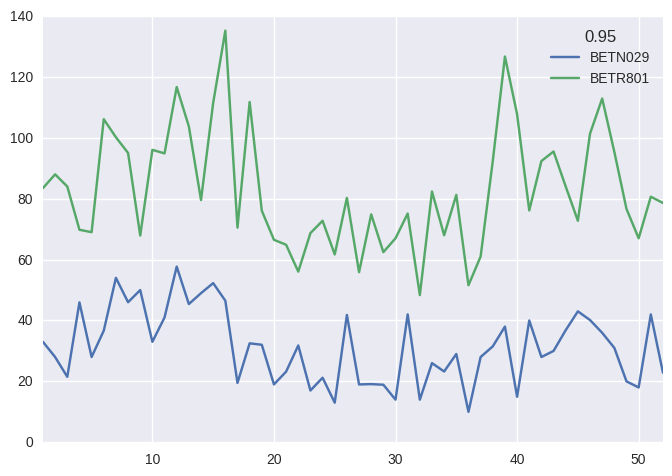

In [20]:
# Groupby wise
df2011 = data['2011']
df2011.groupby(df2011.index.week)[['BETN029', 'BETR801']].quantile(0.95).plot()

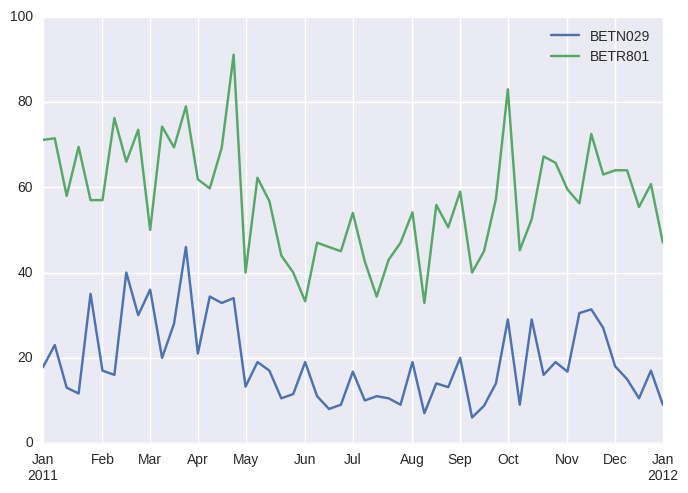

In [21]:
# Resample wise (not possible to use quantile directly on a resample, so you need a lambda function)
# Note the different x-axis labels
df2011[['BETN029', 'BETR801']].resample('W').agg(lambda x: x.quantile(0.75)).plot()

<div class="alert alert-success">

<b>EXERCISE</b>

 <ul>
  <li>Plot the typical diurnal profile (typical hourly averages) for the different stations taking into account the whole time period.</li>

</ul>
</div>

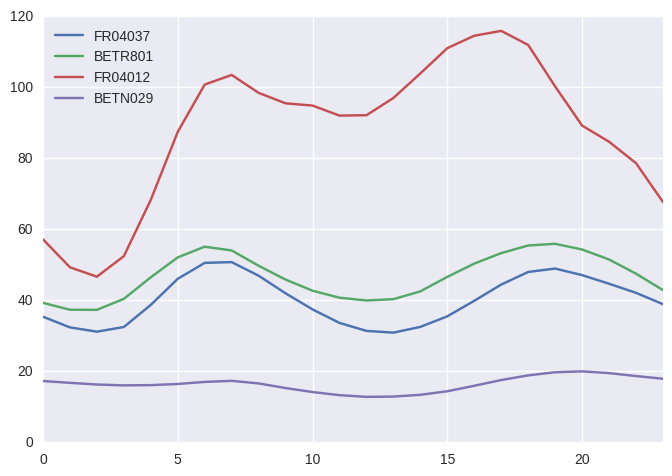

In [22]:
data.groupby(data.index.hour).mean().plot()

<div class="alert alert-success">

<b>EXERCISE</b> <br><br>

What is the difference in the typical diurnal profile between week and weekend days? (and visualise it)<br><br>

**Hints:**

 <ul>
  <li>Add a column 'weekday' defining the different days in the week</li>
  <li>Add a column 'weekend' defining if a days is in the weekend (i.e. days 5 and 6) or not (True/False)</li>
  <li>You can groupby on multiple items at the same time (which at the same time mostly requires an stack or unstack operation</li>


</ul>
</div>

In [23]:
data['weekday'] = data.index.weekday
data['weekend'] = data['weekday'].isin([5, 6])

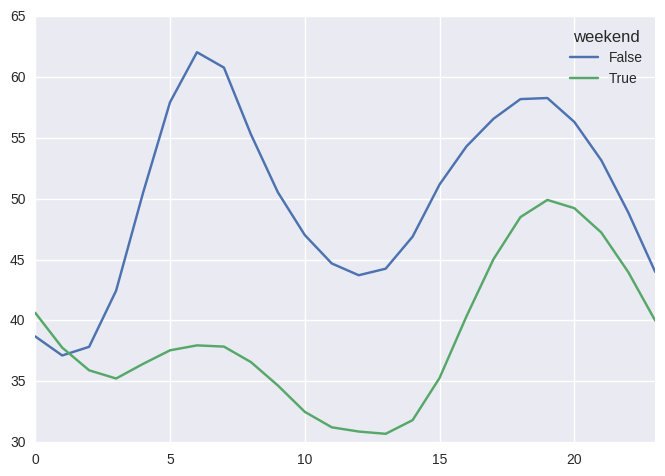

In [24]:
data_weekend = data.groupby(['weekend', data.index.hour]).mean()
data_weekend_BETR801 = data_weekend['BETR801'].unstack(level=0)
data_weekend_BETR801.plot()

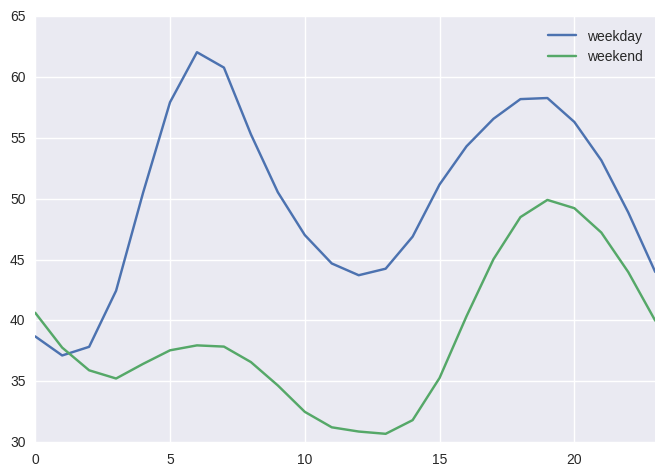

In [25]:
# Cleaning the column names as well to end up with a better legend
data_weekend_BETR801 = data_weekend_BETR801.rename(columns={True: 'weekend', False: 'weekday'})
data_weekend_BETR801.columns.name = None
data_weekend_BETR801.plot()

In [26]:
data = data.drop(['weekday', 'weekend'], axis=1)

<div class="alert alert-success">

<b>EXERCISE</b>:<br><br>

 <ul>
  <li>Calculate the correlation between the different stations (check in the documentation, google "pandas correlation" or use the magic function `%psearch`)</li>

</ul>
</div>


In [27]:
data[['BETR801', 'BETN029', 'FR04037', 'FR04012']].corr()

,BETR801,BETN029,FR04037,FR04012
BETR801,1.000000,0.472954,0.561676,0.394446
BETN029,0.472954,1.000000,0.401864,0.186997
FR04037,0.561676,0.401864,1.000000,0.433466
FR04012,0.394446,0.186997,0.433466,1.000000


<div class="alert alert-success">

<b>EXERCISE</b>:<br><br>

Count the number of exceedances of hourly values above the European limit 200 µg/m3 for each year and station after 2005. Make a barplot of the counts. Add an horizontal line indicating the maximum number of exceedances (which is 18) allowed per year?<br><br>

**Hints:**

 <ul>
  <li>Create a new DataFrame, called `exceedances`, (with boolean values) indicating if the threshold is exceeded or not</li>
  <li>Remember that the sum of True values can be used to count elements</li>
  <li>Adding a horizontal line can be done with the matplotlib function `ax.axhline`</li>


</ul>
</div>

In [28]:
exceedances = data > 200

In [29]:
# group by year and count exceedances (sum of boolean)
exceedances = exceedances.groupby(exceedances.index.year).sum()

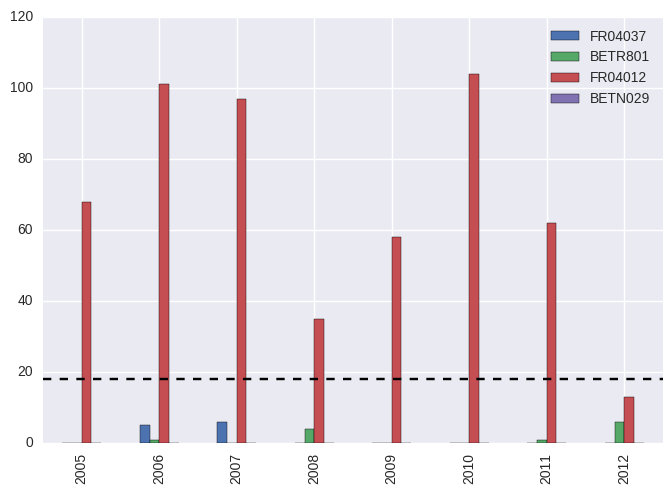

In [30]:
# Make a barplot of the yearly number of exceedances
ax = exceedances.loc[2005:].plot(kind='bar')
ax.axhline(18, color='k', linestyle='--')

<div class="alert alert-info">

<b>INTERMEZZO</b>: The `melt` functionality! <br><br>

Conosider the following example:

</div>

Selecting a subset of data and adding new column:

In [31]:
subset = data['2012-02'].copy()
subset["weekday"] = subset.index.weekday

To be able to use the factorplot of seaborn, we can reformat the data with `stack`

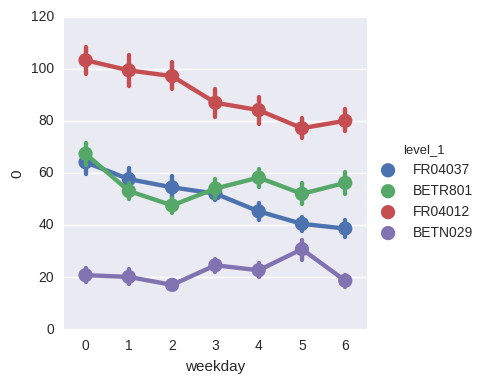

In [32]:
subset2 = subset.set_index("weekday")
stacked = subset2.stack().reset_index()
sns.factorplot(x="weekday", y=0, hue="level_1", data=stacked)

For this type of transformation, there is a shortcut as well, called `melt`:

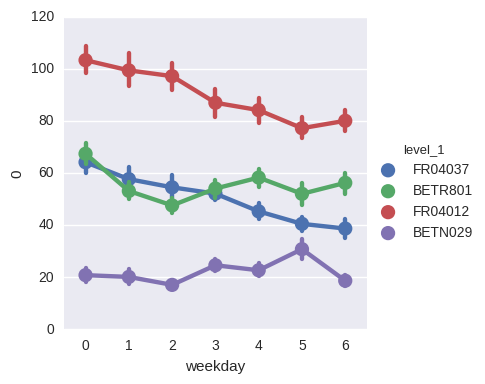

In [33]:
pd.melt(subset, id_vars='weekday')
sns.factorplot(x="weekday", y=0, hue="level_1", data=stacked)

<div class="alert alert-info">

<b>REMEMBER</b>: <br><br>

A shortcut for the command combination:<br>

<code>
subset = subset.set_index("weekday")
stacked = subset.stack().reset_index()
</code><br>

Is given by<br>

<code>
pd.melt(subset, id_vars='weekday')
</code><br>

For more information on the `melt` operation, check the [documentation](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.melt.html)!

</div>

# More advanced exercises...

<div class="alert alert-success">

<b>EXERCISE</b>: Perform the following actions for the station `'FR04012'` only:

 <ul>
  <li>Remove the rows containing `Nan` or zero values</li>
  <li>Sort the values  of the rows according to the air quality values (low to high values)</li>
  <li>Rescale the values to the range [0-1] and store result as `FR_scaled` (Hint: check [wikipedia](https://en.wikipedia.org/wiki/Feature_scaling#Rescaling))</li>
  <li>Plot these values sorted, not taking into account the dates</li>
  <li>Add the station name 'FR04012' as y-label</li>
  <li>[OPTIONAL] Add a vertical line to the plot where the line (hence, the values of variable FR_scaled) reach the value `0.3`. You will need the documentation of `np.searchsorted` and matplotlib's `axvline`</li>
</ul>
</div>

In [34]:
FR_station = data['FR04012'] # select the specific data series
FR_station = FR_station[(FR_station.notnull()) & (FR_station != 0.0)]  # exclude the Nan and zero values

In [35]:
FR_sorted = FR_station.sort_values(ascending=True)
FR_scaled = (FR_sorted - FR_sorted.min())/(FR_sorted.max() - FR_sorted.min())

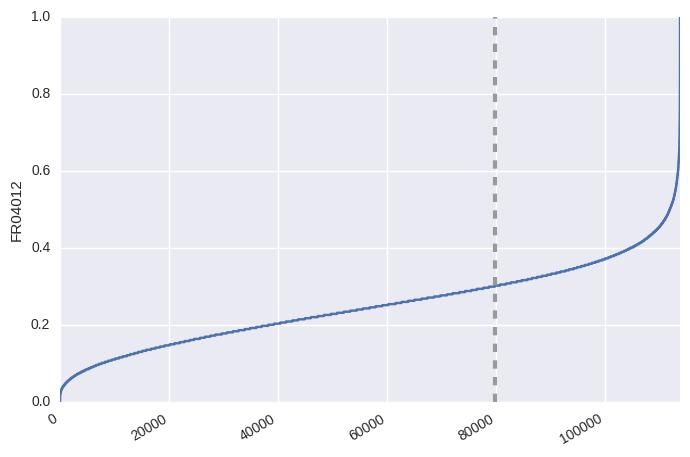

In [37]:
fig, axfr = plt.subplots()
FR_scaled.plot(use_index=False, ax = axfr)  #alternative version: FR_scaled.reset_index(drop=True).plot(use_index=False)  
axfr.set_ylabel('FR04012')
# optional addition, just in case you need this
axfr.axvline(x=FR_scaled.searchsorted(0.3), color='0.6', linestyle='--', linewidth=3)

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>Create a Figure with two subplots (axes), for which both ax**i**s are shared</li>
  <li>In the left subplot, plot the histogram (30 bins) of station 'BETN029', only for the year 2009</li>
  <li>In the right subplot, plot the histogram (30 bins) of station 'BETR801', only for the year 2009</li>
  <li>Add the title representing the station name on each of the subplots, you do not want to have a legend</li>
</ul>
</div>

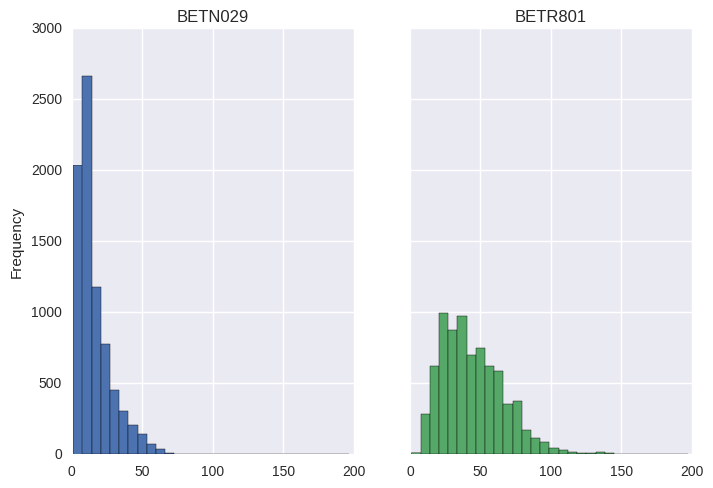

In [38]:
# Mixing an matching matplotlib and Pandas
fig, (ax1, ax2) = plt.subplots(1, 2, 
                               sharex=True, 
                               sharey=True)

data.loc['2009', ['BETN029', 'BETR801']].plot(kind='hist', subplots=True, 
                                              bins=30, legend=False, 
                                              ax=(ax1, ax2))
ax1.set_title('BETN029')
ax2.set_title('BETR801')
# Remark: the width of the bins is calculated over the x data range for both plots together

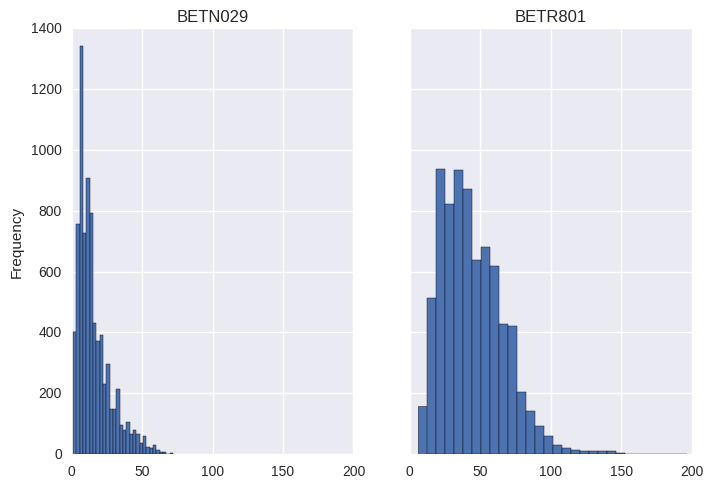

In [39]:
# A more step by step approach (equally valid)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)
data.loc['2009', 'BETN029'].plot(kind='hist', bins=30, ax=ax1)
ax1.set_title('BETN029')
data.loc['2009', 'BETR801'].plot(kind='hist', bins=30, ax=ax2)
ax2.set_title('BETR801')
# Remark: the width of the bins is calculated over the x data range for each plot individually

As an extension on the previous exercise, you could wonder how to do this for all the stations at once. Well, seaborn provides this as a functionality, here just as an example:

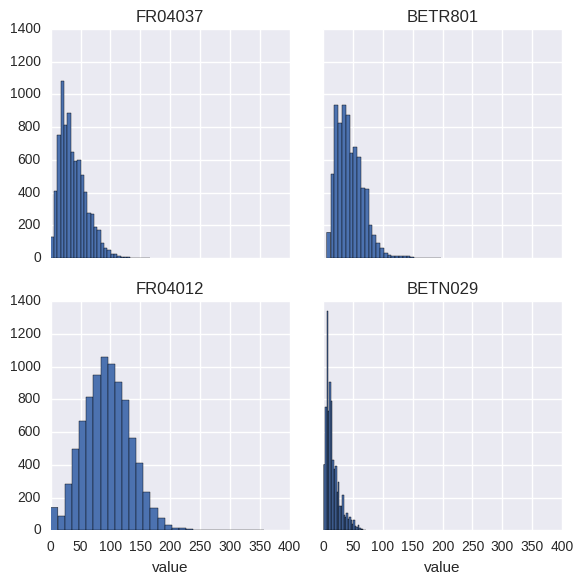

In [40]:
g = sns.FacetGrid(pd.melt(data["2009"]), col="variable", col_wrap=2)
g.map(plt.hist, "value", bins=30)

for station, ax in zip(data.columns, g.axes):
    ax.set_title(station)
# http://seaborn.pydata.org/tutorial/axis_grids.html

<div class="alert alert-success">

<b>EXERCISE</b>

 <ul>
  <li>Make a selectionof the original dataset of the data in January 2009, call the resulting variable `subset`</li>
  <li>Add a new column, called 'weekday', to the variable `subset` which defines for each data point the day of the week</li>
  <li>From the `subset` DataFrame, select only Monday (= day 0) and Sunday (=day 6) and remove the others (so, keep this as variable `subset`)</li>
  <li>Change the values of the weekday column in `subset` according to the following mapping: `{0:"Monday", 6:"Sunday"}`</li>
  <li>Make a linear regression between the stations 'BETN029' and 'FR04037', with a color variation (hue) [based on the weekday column](http://seaborn.pydata.org/tutorial/regression.html#conditioning-on-other-variables)</li>
</ul><br><br>

**Note**: If you run into the **SettingWithCopyWarning** and do not know what to do, recheck [pandas_03_selecting_data](pandas_03_selecting_data.ipynb)

</div>

In [41]:
subset = data['2009-01'].copy()
subset["weekday"] = subset.index.weekday
subset = subset[subset['weekday'].isin([0, 6])]

In [42]:
subset["weekday"] = subset["weekday"].replace(to_replace={0:"Monday", 6:"Sunday"})

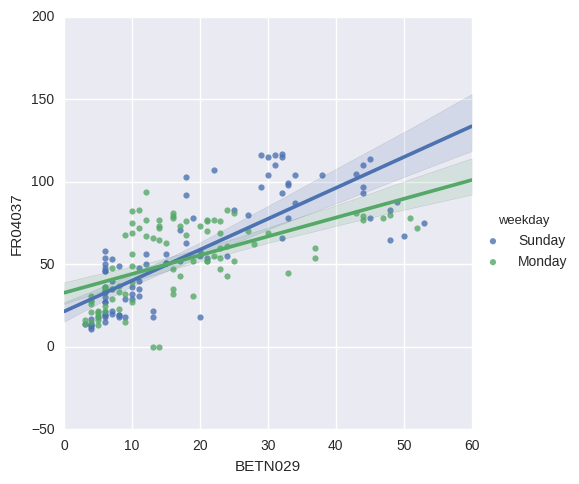

In [43]:
sns.lmplot(x="BETN029", y="FR04037", data=subset, hue="weekday")

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>The maximum daily, 8 hour mean, should be below 100 µg/m³. What is the number of exceedances of this limit for each year/station?</li><br><br>
  </ul>
 
  
**Tip:**<br>

Have a look at the `rolling` method to perform moving window operations.<br><br>

**Note:**<br>
This is not an actual limit for NO$_2$, but a nice exercise to introduce the `rolling` method. Other pollutans, such as 0$_3$ have actually such kind of limit values.

</div>

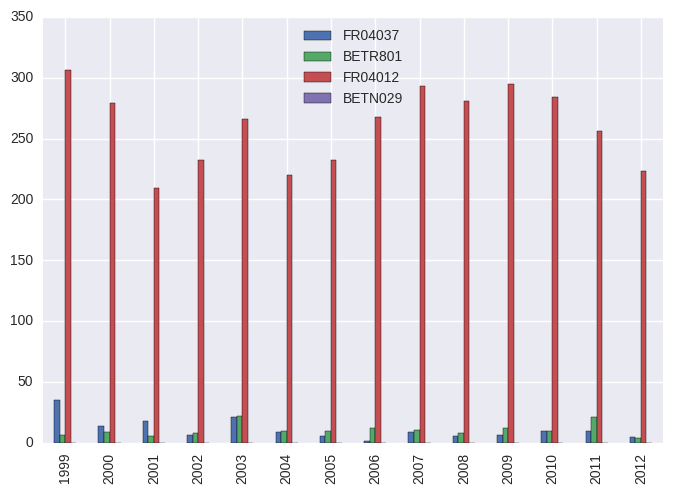

In [44]:
exceedances = data.rolling(8).mean().resample('D').max() > 100
exceedances = exceedances.groupby(exceedances.index.year).sum()
ax = exceedances.plot(kind='bar')

<div class="alert alert-success">

<b>EXERCISE</b>:

 <ul>
  <li>Visualize the typical week profile for the different stations as boxplots (where the values in one boxplot are the *daily means* for the different *weeks* for a certain weekday).</li><br><br>
  </ul>
 
  
**Tip:**<br>

The boxplot method of a DataFrame expects the data for the different boxes in different columns. For this, you can either use `pivot_table` or a combination of `groupby` and `unstack`


</div>


Using pivot_table:

In [45]:
# add a weekday and week column
data['weekday'] = data.index.weekday
data['week'] = data.index.week
data.head()

,FR04037,BETR801,FR04012,BETN029,weekday,week
1999-01-01 00:00:00,68.0,27.0,105.0,13.0,4,53
1999-01-01 01:00:00,70.0,33.0,116.0,15.0,4,53
1999-01-01 02:00:00,72.0,24.0,114.0,16.0,4,53
1999-01-01 03:00:00,72.0,26.0,91.0,18.0,4,53
1999-01-01 04:00:00,74.0,NaN,81.0,19.0,4,53


In [46]:
# pivot table so that the weekdays are the different columns
data_pivoted = data['2012'].pivot_table(columns='weekday', index='week', values='BETR801')
data_pivoted.head()

weekday,0,1,2,3,4,5,6
week,,,,,,,
1,28.545455,25.727273,30.260870,22.704545,44.473684,27.113636,39.590909
2,55.227273,60.113636,50.250000,42.550000,58.704545,68.181818,68.568182
3,73.704545,113.863636,61.045455,43.636364,43.363636,28.826087,22.340909
4,46.944444,71.659091,57.565217,59.833333,65.818182,50.181818,29.500000
5,47.775000,53.750000,41.318182,44.227273,72.250000,76.409091,68.500000


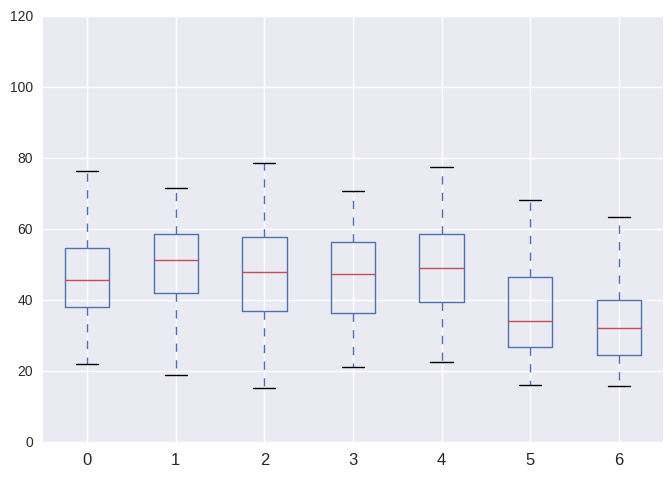

In [47]:
box = data_pivoted.boxplot()

An alternative method using `groupby` and `unstack`:

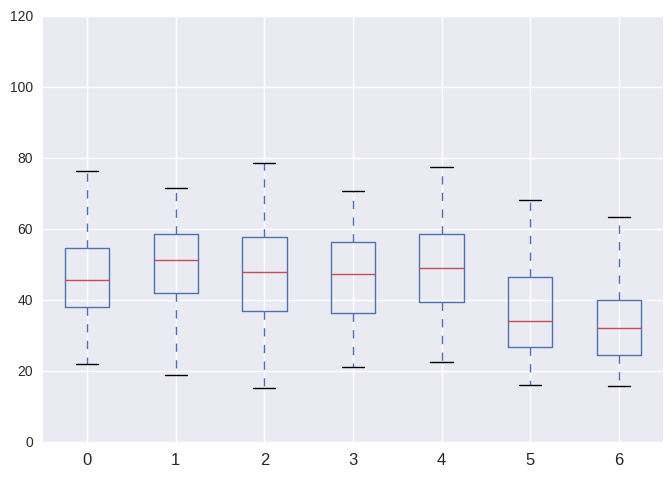

In [48]:
data['2012'].groupby(['weekday', 'week'])['BETR801'].mean().unstack(level=0).boxplot();

In [49]:
data = data.drop(['week', 'weekday'], axis=1)